In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from sklearn.datasets import make_moons
from torchvision import transforms
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

In [401]:
#data 불러오기
x, y = make_moons(n_samples=4000, noise=0.1)

#train, test split 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

#x_label과 x_unlabel dataset 만들기 
index = int(x_train.shape[0]*0.5)

x_label = x_train[:index]
y_label = y_train[:index]
x_unlabel = x_train[index:]

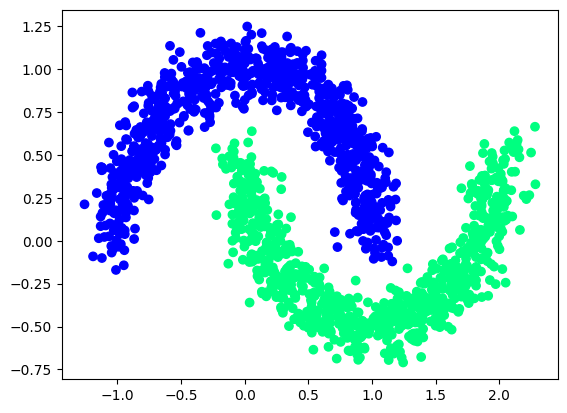

In [402]:
# plot 
plt.scatter(x_label[:,0], x_label[:,1], c=y_label, cmap=plt.cm.winter)

### Custom dataset

In [403]:
# Dataset 상속
class train_label_Dataset(Dataset): 
  def __init__(self,x_label,y_label,x_unlabel):
    self.x_label = x_label
    self.y_label = y_label
    self.x_unlabel = x_unlabel

  def __len__(self): 
    return len(self.x_label)


  def __getitem__(self, idx): 
    x = torch.DoubleTensor(self.x_label[idx:idx+1])
    y = torch.DoubleTensor(self.y_label[idx:idx+1])
    z = torch.DoubleTensor(self.x_unlabel[idx:idx+1])
    x = x.view(-1,)
    y = y.view(-1,)
    z = z.view(-1,)
    return x, y, z

# class train_unlabel_Dataset(Dataset): 
#   def __init__(self,x_unlabel):
#     self.x_unlabel = x_unlabel
    
#   # 총 데이터의 개수를 리턴
#   def __len__(self): 
#     return len(self.x_unlabel)
  
#   # 데이터의 shape을 return
#   def __shape__(self):
#     return (self.x_unlabel.shape)
  
#   # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
#   def __getitem__(self, idx): 
#     x = torch.FloatTensor(self.x_label[idx:idx+1])
#     x = x.view(-1,)
#     return x

class testDataset(Dataset): 
  def __init__(self,x_test,y_test):
    self.x_test = x_test
    self.y_test = y_test
    
  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_test)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = torch.DoubleTensor(self.x_test[idx:idx+1])
    y = torch.DoubleTensor(self.y_test[idx:idx+1])
    x = x.view(-1,)
    y = y.view(-1,)
    return x, y



In [393]:
# Noise Function
def noise_fn(x): 
    mu =0, 
    sigma = 0.1 
    noise = np.random.normal(mu,sigma,[np.shape(x)[0],np.shape(x)[1]])
    x = x + noise
    return x

### hyper-parameter

In [394]:
input_size = 2
hidden_size = 10
output_size = 1
BATCH_SIZE = 32
EPOCHS = 1000
DEVICE = 'mps'
lr= 0.001
K=2
T=0.5

### DataLoader

In [404]:
train_label_Dataset=train_label_Dataset(x_label,y_label,x_unlabel)
train_label_Dataloader = DataLoader(train_label_Dataset, batch_size=BATCH_SIZE, shuffle=True,)
# train_unlabel_Dataset = train_unlabel_Dataset(x_unlabel)
# train_unlabel_Dataloader = DataLoader(train_unlabel_Dataset, batch_size=BATCH_SIZE, shuffle=True,)
test_dataset = testDataset(x_test,y_test)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True, )

### model

In [396]:
class NET(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.NN =nn.Sequential(
            nn.Linear(input_size,hidden_size).double(),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size).double(),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size).double(),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.NN(x)

In [397]:
model = NET(input_size,hidden_size,output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()

### TRAIN

In [398]:
losses = []

for epoch in range(EPOCHS):
    model.train()
    cost = 0.0

    for step, (x_label,y_label,x_unlabel) in enumerate(train_label_Dataloader):
        x_label, y_label, x_unlabel = x_label, y_label, x_unlabel

        x = noise_fn(x_label) #augment x 
        u = [noise_fn(x_unlabel) for _ in range(K)] #augment
        q = sum(map(lambda i: model(i), u)) / K
        Ux = np.concatenate(u, axis=0)
        q_temp = q.detach().numpy() 
        Uy = np.concatenate([q_temp for _ in range(K)], axis=0)
        Uy=torch.DoubleTensor(Uy)
        
        optimizer.zero_grad()
         
        output1 = model(x)
        output2 = model(torch.DoubleTensor(Ux))
        loss = criterion1(output1,y_label) + 100 * criterion2(output2,Uy) 
        loss.backward()
        optimizer.step()
        cost = cost + loss.item()

    
    cost  = cost / len(train_label_Dataloader)
    losses.append(cost)
    if (epoch + 1) % 30 == 0:
        print(f"Training Epoch : {epoch+1:1d}, training loss : {cost:.3f}")
  

Training Epoch : 30, training loss : 0.283
Training Epoch : 60, training loss : 0.217
Training Epoch : 90, training loss : 0.179
Training Epoch : 120, training loss : 0.210
Training Epoch : 150, training loss : 0.181
Training Epoch : 180, training loss : 0.170
Training Epoch : 210, training loss : 0.203
Training Epoch : 240, training loss : 0.182
Training Epoch : 270, training loss : 0.197
Training Epoch : 300, training loss : 0.201
Training Epoch : 330, training loss : 0.166
Training Epoch : 360, training loss : 0.159
Training Epoch : 390, training loss : 0.168
Training Epoch : 420, training loss : 0.184
Training Epoch : 450, training loss : 0.166
Training Epoch : 480, training loss : 0.201
Training Epoch : 510, training loss : 0.195
Training Epoch : 540, training loss : 0.184
Training Epoch : 570, training loss : 0.168
Training Epoch : 600, training loss : 0.176
Training Epoch : 630, training loss : 0.163
Training Epoch : 660, training loss : 0.174
Training Epoch : 690, training loss

Text(0, 0.5, 'loss')

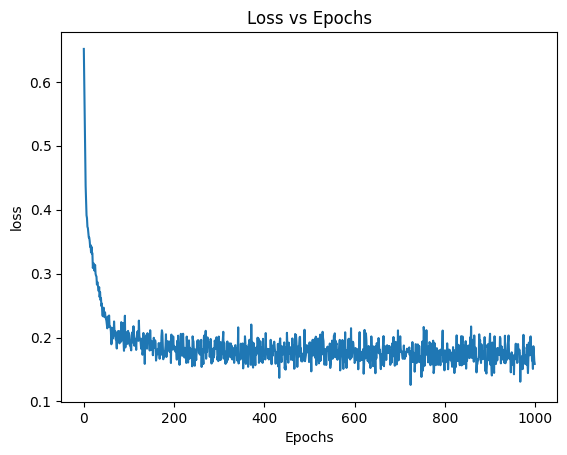

In [399]:
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

### TEST

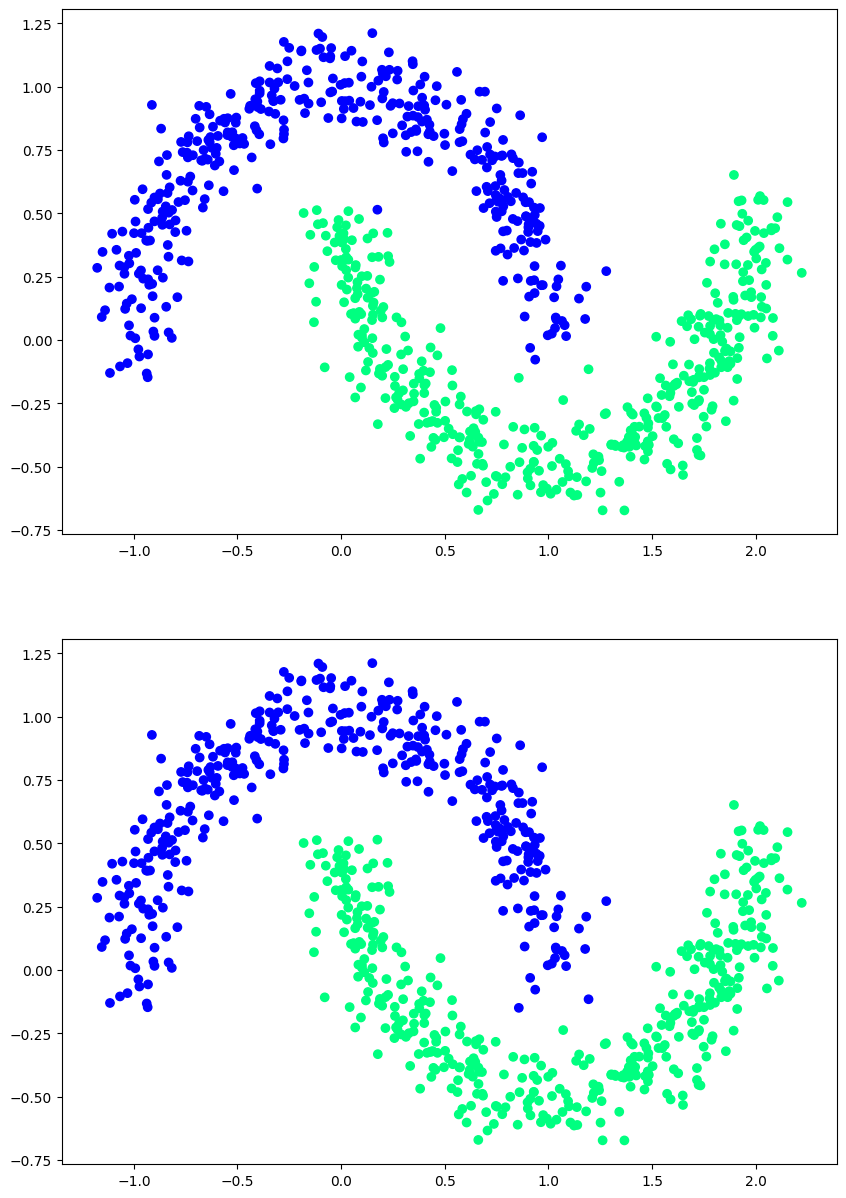

In [423]:
model.eval()
y_true = []
y_pred = []

plt.figure(figsize=(10,15))
# set the requires_grad flag to false as we are in the test mode
with torch.no_grad():
    for step, (data, target) in enumerate(test_loader):
        # moving the tensors to the configured device
        data, target = data , target
        # the model on the data
        output = model(data)
        
        #PREDICTIONS
        pred = torch.round(output)
        plt.subplot(211)
        plt.scatter(data[:,0], data[:,1], c=pred, cmap=plt.cm.winter)

        plt.subplot(212)
        plt.scatter(data[:,0], data[:,1], c=target, cmap=plt.cm.winter)